# Compare the analytical solution and the neural net mask

In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
import sys
sys.path.append("..")
from utils.model import Net_mask
from utils.data import Data
from scripts.parameters import get_parameters, get_parameters_2
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.distributions.multivariate_normal import MultivariateNormal

In [11]:
model = Net_mask()
model2 = Net_mask()
data = Data
run = 0
outer_folder = 'map'
#outer_folder_2 = 'map_numpy'
outer_folder_2 = 'map_1000'
name = '../saved_models/' + str(outer_folder) + '/' + str(run) + '/model_weights.pth'
name2 = '../saved_models/' + str(outer_folder_2) + '/' + str(run) + '/model_weights.pth'
model.load_state_dict(torch.load(name))
model2.load_state_dict(torch.load(name2))
model.eval()
model2.eval()

Net_mask(
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=30, bias=True)
    (1): ReLU()
    (2): Linear(in_features=30, out_features=10, bias=True)
  )
)

In [12]:
tensor_mu_m, tensor_Sigma_m, tensor_mu_eps, tensor_Sigma_eps, tensor_Q_m, sigma2_eps, tau2 = get_parameters()
tensor_mu_m2, tensor_Sigma_m2, tensor_mu_eps2, tensor_Sigma_eps2, tensor_Q_m2, sigma2_eps2, tau22 = get_parameters_2()
data = Data(tensor_mu_m, tensor_Sigma_m, tensor_mu_eps, tensor_Sigma_eps)
data2 = Data(tensor_mu_m2, tensor_Sigma_m2, tensor_mu_eps2, tensor_Sigma_eps2)

In [13]:

tensor_data = torch.zeros(1, 20)
tensor_d_sample =  MultivariateNormal(loc=torch.zeros(10), covariance_matrix=(torch.eye(10)*1)).sample(sample_shape=(1,))
tensor_n_masked = torch.randint(10, (1,))
tensor_masks = torch.rand(1, 10).argsort(dim=1)
tensor_masks = (tensor_masks < tensor_n_masked.unsqueeze(1))*1
tensor_data[:,:10] = tensor_d_sample*tensor_masks
tensor_data[:,10:] = tensor_masks
tensor_data
tensor_data = data.get_tensor_data(1, [2.5, 1.5, -3], [1, 3, 8])

In [14]:
post, _ = data.get_tensor_posterior(tensor_data[0])
post2, _ = data2.get_tensor_posterior(tensor_data[0])
out_raw = model(tensor_data)
out_raw2 = model2(tensor_data)
out = out_raw[0].detach().numpy()
out2 = out_raw2[0].detach().numpy()
d = tensor_data[0][:10]
mask = tensor_data[0][10:]
location_raw = torch.where(mask > 0.5)
location = location_raw[0]

(0.0, 10.0, -3.0, 3.0)

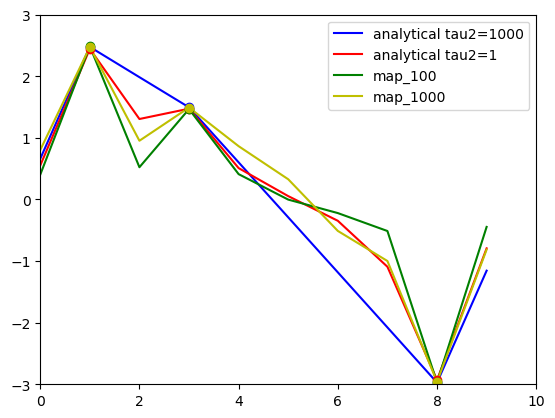

In [15]:
plt.plot(range(10), post, 'b')
plt.plot(range(10), post2, 'r')
plt.plot(range(10), out, 'g')
plt.plot(range(10), out2, 'y')
plt.plot(location, post[location_raw], 'bo')
plt.plot(location, post2[location_raw], 'ro')
plt.plot(location, out[location_raw], 'go')
plt.plot(location, out2[location_raw], 'yo')
#plt.legend(['analytical tau2=1000', 'analytical tau2=1', 'map'])
plt.legend(['analytical tau2=1000', 'analytical tau2=1', 'map_100', 'map_1000'])
plt.axis([0,10,-3,3])

In [16]:
from utils.loss3 import Loss
loss = Loss()
import utils.loss3 as l3
l3l = l3.Loss()
tensor_data = tensor_data.type(torch.DoubleTensor)
post = post.type(torch.DoubleTensor)
out_raw = out_raw.type(torch.DoubleTensor)
out_raw2 = out_raw2.type(torch.DoubleTensor)
loss1 = loss.loss(tensor_data, torch.unsqueeze(post, 0), 'm', 'c', 'i') 
loss2 = loss.loss(tensor_data, out_raw, 'm', 'c', 'i') 
loss3 = loss.loss(tensor_data, out_raw2, 'm', 'c', 'i') 
l3value = l3l.loss(tensor_data, torch.unsqueeze(post, 0), 'm', 'c', 'i')
print(loss1[0])
print(loss2[0])
print(loss3[0])
print(l3value[0])

tensor(0.1289, dtype=torch.float64)
tensor(0.2103, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.2247, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.1289, dtype=torch.float64)
